In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

/Users/more/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Data Preparation

In [130]:
df = pd.read_json('../data/train.json')
df["num_photos"] = df["photos"].apply(len)
df["num_features"] = df["features"].apply(len)
df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
df["created"] = pd.to_datetime(df["created"])
df["created_year"] = df["created"].dt.year
df["created_month"] = df["created"].dt.month
df["created_day"] = df["created"].dt.day
df["bath_bed_sum"] = df['bathrooms'] + df['bedrooms']
df["bath_bed_diff"] = df['bathrooms'] - df['bedrooms']
df["price_per_bed"] = df['price'] / df['bedrooms']
df["price_per_bath"] = df['price'] / df['bathrooms']
df["price_per_room"] = df['price'] / df['bath_bed_sum']
features_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", "price_per_bed",
                   "price_per_bath", "price_per_room", "bath_bed_diff", "bath_bed_sum",]

# manage_id

In [157]:
from sklearn import preprocessing
X = df.drop(['interest_level'], axis = 1)
y = df['interest_level']

lbl = preprocessing.LabelEncoder()
lbl.fit(list(X['manager_id'].values))
X.loc[:, 'manager_id'] = lbl.transform(list(X['manager_id'].values))
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.33)
# print X_tr.reset_index().loc[1,:]

temp = pd.concat([X_tr.manager_id, pd.get_dummies(y_tr)], axis = 1).groupby('manager_id').mean()
temp.columns = ['high_frac','low_frac', 'medium_frac']
temp['count'] = X_tr.groupby('manager_id').count().iloc[:,1]
temp['manager_skill'] = temp['high_frac']*2 + temp['medium_frac']

In [137]:
low_count_managers_idx = temp['count'] < 20
assessed_managers_idx = ~low_count_managers_idx
mean_values = temp.loc[assessed_managers_idx, ['high_frac', 'low_frac', 'medium_frac', 'manager_skill']].mean()
temp.loc[low_count_managers_idx,['high_frac', 'low_frac', 'medium_frac', 'manager_skill']] = mean_values.values

# inner join to assign manager features to the managers in the training dataframe
X_tr = X_tr.merge(temp.reset_index(),how= 'left', left_on='manager_id', right_on='manager_id')

# add the features computed on the training dataset to the validation dataset
X_val = X_val.merge(temp.reset_index(), how='left', left_on='manager_id', right_on='manager_id')
new_manager_idx = X_val['high_frac'].isnull()
X_val.loc[new_manager_idx,['high_frac','low_frac', 'medium_frac','manager_skill']] = mean_values.values

features_to_use.extend(['high_frac', 'low_frac', 'medium_frac','manager_skill'])

# visualize

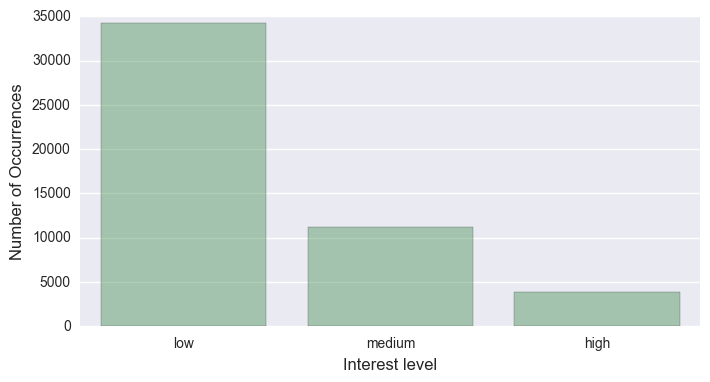

In [9]:
level_counts = df['interest_level'].value_counts()

plt.figure(figsize=(8,4))
sb.barplot(level_counts.index, level_counts.values, alpha=0.5, color=sb.color_palette()[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Interest level', fontsize=12)
plt.show()

(0, 300)

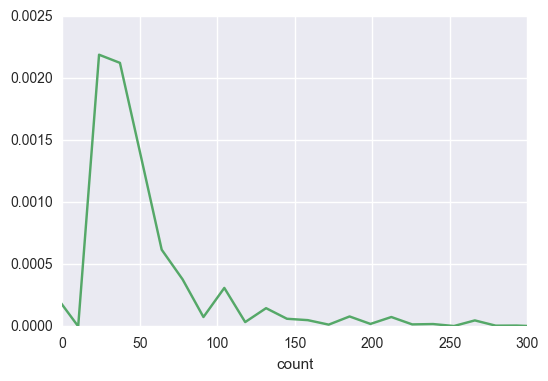

In [10]:
fig = plt.figure()
ax = fig.gca()
sb.distplot(temp['count'], hist=False, color=sb.color_palette()[1])
ax.set_xlim(0, 300)

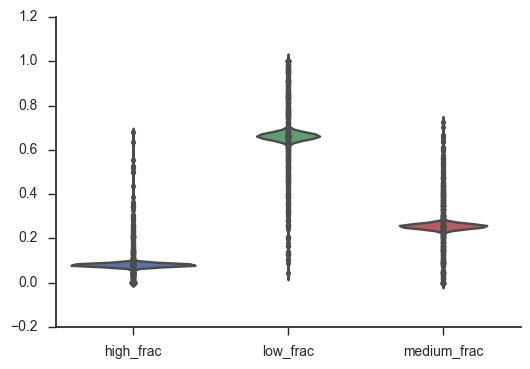

In [11]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots()
    sb.violinplot(data=temp.loc[:, ['high_frac','low_frac', 'medium_frac']], inner="points", ax=ax)    
    sb.despine()

In [138]:
# from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.ensemble import RandomForestClassifier

ft_to_use = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day"]
clf = XGBClassifier(objective='multi:softmax')
clf.fit(X_tr[ft_to_use] , y_tr)
loss = log_loss(y_val, clf.predict_proba(X_val[ft_to_use]))
print 'baseline', loss

baseline 0.646465368729


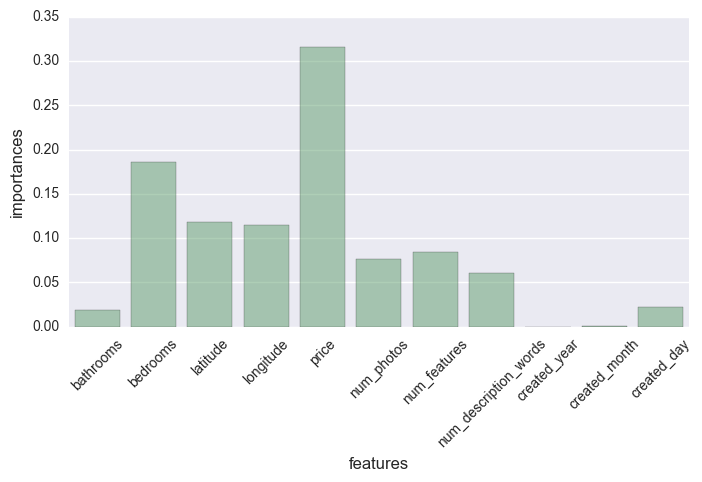

In [116]:
plt.figure(figsize=(8,4))
g = sb.barplot(ft_to_use, clf.feature_importances_, alpha=.5, color=sb.color_palette()[1])
plt.xticks(rotation=45)
plt.ylabel('importances', fontsize=12)
plt.xlabel('features', fontsize=12)
plt.savefig('xgboost_baseline.png')
plt.show()

In [141]:
ft_to_use.extend(["manager_skill", "count"])
clf = XGBClassifier(objective='multi:softmax')
clf.fit(X_tr[ft_to_use] , y_tr)
loss = log_loss(y_val, clf.predict_proba(X_val[ft_to_use]))
print 'baseline', loss

baseline 0.618321757788


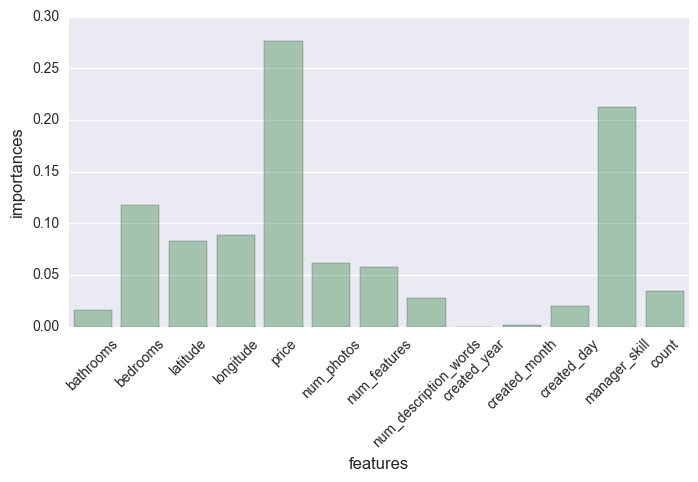

In [142]:
plt.figure(figsize=(8,4))
g = sb.barplot(ft_to_use, clf.feature_importances_, alpha=.5, color=sb.color_palette()[1])
plt.xticks(rotation=45)
plt.ylabel('importances', fontsize=12)
plt.xlabel('features', fontsize=12)
plt.savefig('xgboost_baseline.png')
plt.show()